In [1]:
import pandas as pd
from nba_api.stats.endpoints.playergamelog import PlayerGameLog
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.teamestimatedmetrics import TeamEstimatedMetrics
from nba_api.stats.endpoints.commonteamroster import CommonTeamRoster
from nba_api.stats.static import players, teams
import datetime 

In [2]:
#Load Torn Achilles Data
def load_injury_dataset(filepath):
    return  pd.read_csv(filepath, parse_dates=["Date Of Injury"])

In [3]:
#Get Player ID From Name 
def get_player_id(player_name):
    matches = players.find_players_by_full_name(player_name)
    if len(matches) == 0:
        raise ValueError(f"No player found with name: {player_name}")
    return matches[0]['id']

In [4]:
#Get Team ID
def get_team_id(team_name):
    team_name = team_name.strip().lower()
    all_teams = teams.get_teams()

    for team in all_teams:
        if team_name in team['full_name'].lower():
            return team['id']
        if team_name in team['abbreviation'].lower():
            return team['id']

    raise ValueError(f"No team found with name: {team_name}")

In [5]:
#Get Season of Injury 
def season_from_date(injury_date):
    year = injury_date.year
    if injury_date.month >= 10:
        return f"{year}-{str(year+1)[-2:]}"
    else:
        return f"{year-1}-{str(year)[-2:]}" 

In [6]:
#Get Players Season Game Log
def get_player_game_log(player_name, injury_date):
    season = season_from_date(injury_date)
    player_id = get_player_id(player_name)

    print(f"Fetching game logs for {player_name} in {season}")

    # Regular Season
    gamelog_regular = playergamelog.PlayerGameLog(
        player_id=player_id,
        season=season,
        season_type_all_star='Regular Season'
    ).get_data_frames()[0]

    # Playoffs
    gamelog_playoffs = playergamelog.PlayerGameLog(
        player_id=player_id,
        season=season,
        season_type_all_star='Playoffs'
    ).get_data_frames()[0]

    # Preseason
    gamelog_preseason = playergamelog.PlayerGameLog(
        player_id=player_id,
        season=season,
        season_type_all_star='Pre Season'
    ).get_data_frames()[0]

    # Combine all
    logs = [gamelog_regular, gamelog_playoffs, gamelog_preseason]
    logs = [log for log in logs if not log.empty]  # Exclude empty DataFrames
    gamelog = pd.concat(logs, ignore_index=True)

    gamelog['GAME_DATE'] = pd.to_datetime(gamelog['GAME_DATE'])
    gamelog = gamelog.sort_values('GAME_DATE')

    return gamelog, season


In [7]:
#Get Players Workload 
import pandas as pd
from nba_api.stats.endpoints import playergamelog  # ← this is essential

def compute_workload_stats(gamelog_df, injury_date):
    gamelog_df['GAME_DATE'] = pd.to_datetime(gamelog_df['GAME_DATE'])
    gamelog_df['MIN'] = pd.to_numeric(gamelog_df['MIN'], errors='coerce')

    games_before_injury = gamelog_df[gamelog_df['GAME_DATE'] < injury_date]
    games_played = len(games_before_injury)
    avg_minutes = pd.to_numeric(games_before_injury['MIN'], errors='coerce').mean()

    one_week_ago = injury_date - pd.Timedelta(days=7)
    games_last_week = games_before_injury[games_before_injury['GAME_DATE'] >= one_week_ago]
    minutes_within_a_week = pd.to_numeric(games_last_week['MIN'], errors='coerce').sum()

    one_month_ago = injury_date - pd.Timedelta(days=30)
    games_last_month = games_before_injury[games_before_injury['GAME_DATE'] >= one_month_ago]
    minutes_within_a_month = pd.to_numeric(games_last_month['MIN'], errors='coerce').sum()

    if len(games_before_injury) > 0:
        last_game_date = games_before_injury['GAME_DATE'].max()
        rest_days = (injury_date - last_game_date).days
    else:
        rest_days = None

    return {
        'Games Played Before Injury': games_played,
        'Average Minutes Per Game': avg_minutes,
        'Minutes In Last Week': minutes_within_a_week,
        'Minutes In Last Month': minutes_within_a_month,
        'Rest Days Before Injury': rest_days
    }



In [8]:
#Get Player ID
def get_player_id(player_name):
    player_name = player_name.strip()  
    print(f"Searching for player: {repr(player_name)}")
    matches = players.find_players_by_full_name(player_name)
    if len(matches) == 0:
        print(f"No player found with name: {player_name}")
        return None

    if len(matches) > 1:
        print(f"Multiple matches for {player_name}:") 
        for i, match in enumerate(matches):
            print(f" {i+1}: {match['full_name']} (ID: {match['id']})")
    player_id = matches[0]['id'] 
    print(f"Using player ID: {player_id} for {player_name}")
    return player_id

In [9]:
#Get Team Pace
def get_team_pace(team_id, season):
    pace_df = TeamEstimatedMetrics(season=season).get_data_frames()[0]
    print("Available columns:", pace_df.columns)


    team_row = pace_df[pace_df['TEAM_ID'] == team_id]
    
    if team_row.empty:
        raise ValueError(f"No pace data found for team_id: {team_id} in season {season}")
    
    team_pace = team_row['E_PACE'].values[0]
    
    return team_pace


In [12]:
import pandas as pd
import time
import traceback

def combine_data(injury_df):
    combined_data = []

    for _, row in injury_df.iterrows():
        player_name = row['Player']
        injury_date = row['Date Of Injury']
        team_name = row[' Team']
        game_time = row['Time Into Game']
        opponent = row['Opponent']

        try:
            print(f"Getting game log for {player_name} on {injury_date}")
            gamelog, season = get_player_game_log(player_name, injury_date)
            print(f"Got gamelog: {type(gamelog)}, season: {season}")
            # The next line might be a source of error if gamelog is empty
            if not gamelog.empty:
                print(gamelog[gamelog['MIN'] > 0].tail(5))

            workload_stats = compute_workload_stats(gamelog, injury_date)
            print(f"DEBUG: {player_name}'s workload_stats: {workload_stats} (type: {type(workload_stats)})")
            
            team_id = get_team_id(team_name)
            opponent_id = get_team_id(opponent)
            opponent_pace = get_team_pace(opponent_id, season)
            pace = get_team_pace(team_id, season)

            if all([workload_stats, team_id, opponent_id, pace is not None]):
                combined_data.append({
                    'Player': player_name,
                    'Injury Date': injury_date,
                    'Season': season,
                    'Team NAME': team_name,
                    'Games Played Before Injury': workload_stats.get('Games Played Before Injury', None),
                    'Average Minutes Per Game': workload_stats.get('Average Minutes Per Game', None),
                    'Minutes In Last Week': workload_stats.get('Minutes In Last Week', None),
                    'Minutes In Last Month': workload_stats.get('Minutes In Last Month', None),
                    'Rest Days Before Injury': workload_stats.get('Rest Days Before Injury', None),
                    'Team Pace': pace,
                    'Estimated Minutes at Injury': game_time,
                    'Opponent Pace': opponent_pace
                })
            else:
                print(f"Skipping {player_name} due to missing data.")

        except Exception as e:
            print(f"Failed for {player_name}: {e}")
            traceback.print_exc()
            continue

        time.sleep(1.5)

    return pd.DataFrame(combined_data)

In [13]:
if __name__ == '__main__':
    injury_filepath = 'TornAchillesData.csv'
    df = load_injury_dataset(injury_filepath)
    print("Loaded columns:", df.columns)
    combined_df = combine_data(df)
    combined_df.to_csv('combined_data.csv', index=False)
    print("Saved combined injury dataset.")

Loaded columns: Index(['Player', 'Date Of Injury', 'Time Into Game', 'Opponent',
       'Type Of Game', ' Team'],
      dtype='object')
Getting game log for Klay Thompson on 2020-11-19 00:00:00
Searching for player: 'Klay Thompson'
Using player ID: 202691 for Klay Thompson
Fetching game logs for Klay Thompson in 2020-21
Failed for Klay Thompson: No objects to concatenate
Getting game log for Chris Clemons on 2020-12-15 00:00:00
Searching for player: 'Chris Clemons'
Using player ID: 1629598 for Chris Clemons
Fetching game logs for Chris Clemons in 2020-21


Traceback (most recent call last):
  File "/var/folders/nc/6b1jm_5916jfsb2z3pbyrr_00000gn/T/ipykernel_3742/3066657632.py", line 17, in combine_data
    gamelog, season = get_player_game_log(player_name, injury_date)
  File "/var/folders/nc/6b1jm_5916jfsb2z3pbyrr_00000gn/T/ipykernel_3742/2554009978.py", line 32, in get_player_game_log
    gamelog = pd.concat(logs, ignore_index=True)
  File "/Users/jacquelinekloner/anaconda3/envs/nba_env/lib/python3.10/site-packages/pandas/core/reshape/concat.py", line 382, in concat
    op = _Concatenator(
  File "/Users/jacquelinekloner/anaconda3/envs/nba_env/lib/python3.10/site-packages/pandas/core/reshape/concat.py", line 445, in __init__
    objs, keys = self._clean_keys_and_objs(objs, keys)
  File "/Users/jacquelinekloner/anaconda3/envs/nba_env/lib/python3.10/site-packages/pandas/core/reshape/concat.py", line 507, in _clean_keys_and_objs
    raise ValueError("No objects to concatenate")
ValueError: No objects to concatenate


Got gamelog: <class 'pandas.core.frame.DataFrame'>, season: 2020-21
  SEASON_ID  Player_ID     Game_ID  GAME_DATE      MATCHUP WL  MIN  FGM  FGA  \
2     12020    1629598  0012000003 2020-12-11    HOU @ CHI  W   17    1    8   
1     12020    1629598  0012000016 2020-12-13    HOU @ CHI  L   17    3    8   
0     12020    1629598  0012000026 2020-12-15  HOU vs. SAS  W    5    1    2   

   FG_PCT  ...  DREB  REB  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  \
2   0.125  ...     1    1    1    0    0    0   3    5          -1   
1   0.375  ...     5    5    1    0    2    2   2    7         -14   
0   0.500  ...     2    2    2    0    0    0   1    3           7   

   VIDEO_AVAILABLE  
2                1  
1                1  
0                1  

[3 rows x 27 columns]
DEBUG: Chris Clemons's workload_stats: {'Games Played Before Injury': 2, 'Average Minutes Per Game': 17.0, 'Minutes In Last Week': 34, 'Minutes In Last Month': 34, 'Rest Days Before Injury': 2} (type: <class 'dict'>)
Availa

In [14]:
# Example manual test outside the function
player_name = "Tyrese Haliburton"
injury_date = pd.to_datetime("2025-06-22")

# Get the player’s gamelog and season (same as your function)
gamelog, season = get_player_game_log(player_name, injury_date)

# Make sure GAME_DATE is datetime
gamelog['GAME_DATE'] = pd.to_datetime(gamelog['GAME_DATE'])

# Check the last 5 games he played before the injury
games_before_injury = gamelog[gamelog['GAME_DATE'] < injury_date]
print(games_before_injury[['GAME_DATE', 'MIN']].sort_values('GAME_DATE', ascending=False).head())



Searching for player: 'Tyrese Haliburton'
Using player ID: 1630169 for Tyrese Haliburton
Fetching game logs for Tyrese Haliburton in 2024-25
    GAME_DATE  MIN
74 2025-06-19   23
75 2025-06-16   34
76 2025-06-13   36
77 2025-06-11   36
78 2025-06-08   34


In [15]:
!pip install matplotlib seaborn

Getting stats for 2020-21
Getting stats for 2022-23
Getting stats for 2024-25


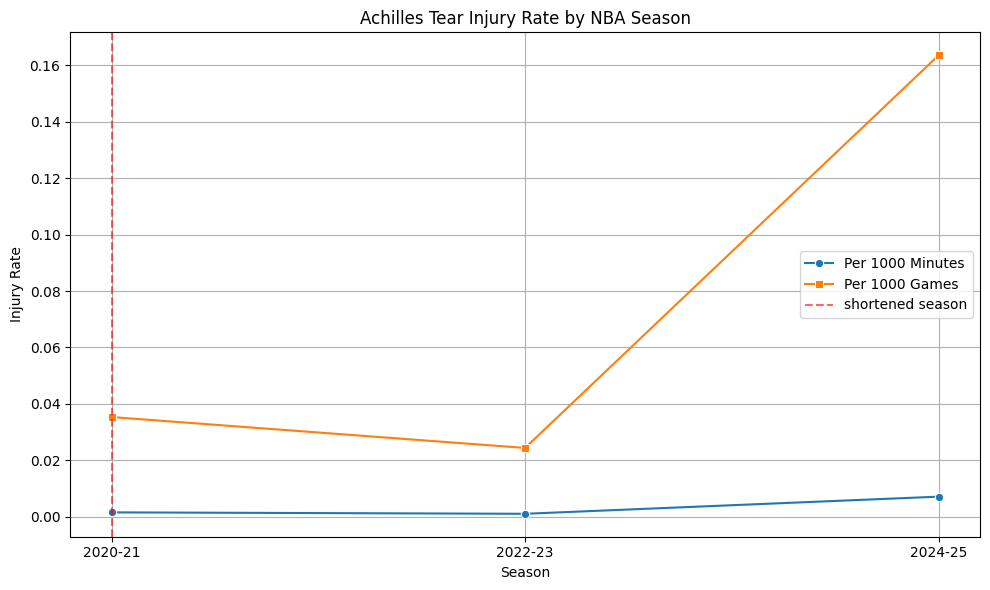

In [16]:
#EDA: Injury Rates by season 
import time 
import matplotlib.pyplot as plt
import seaborn as sns
from nba_api.stats.endpoints import LeagueDashPlayerStats


#Load season data from csv with the achilles injury information 
achilles_torn_df = pd.read_csv("combined_data.csv")
achilles_torn_df['Season'] = achilles_torn_df['Season'].astype(str)
achilles_torn_counts = achilles_torn_df['Season'].value_counts().rename('Achilles Torn Per Season').sort_index()

#Get games and minutes played in NBA overall to calculate injury rate per season
seasons = sorted(achilles_torn_counts.index)
season_minutes = {}

for season in seasons:
    print(f"Getting stats for {season}") 
    stats = LeagueDashPlayerStats(season=season, per_mode_detailed='Totals')
    df = stats.get_data_frames()[0]

    total_minutes = df['MIN'].sum()
    total_games = df['GP'].sum()

    season_minutes[season] = {
        'Total Minutes': total_minutes,
        'Total Games': total_games
    }

    time.sleep(1.5)

#Merge datasets and compute injury rate
rate_df = pd.DataFrame.from_dict(season_minutes, orient='index')
rate_df.index.name = 'Season'
rate_df.reset_index(inplace=True)

rate_df = rate_df.merge(achilles_torn_counts, on='Season', how='left')
rate_df['Achilles Torn Per Season'] = rate_df['Achilles Torn Per Season'].fillna(0)

rate_df['Tears per 1000 Minutes'] = (rate_df['Achilles Torn Per Season'] / rate_df['Total Minutes']) *1000
rate_df['Tears per 1000 Games'] = (rate_df['Achilles Torn Per Season'] / rate_df['Total Games']) *1000

#Plot Rates 
#HighLight Shortened Seasons    
plt.figure(figsize=(10,6))
sns.lineplot(data=rate_df, x='Season', y='Tears per 1000 Minutes', marker='o', label='Per 1000 Minutes')
sns.lineplot(data=rate_df, x='Season', y='Tears per 1000 Games', marker='s', label='Per 1000 Games')

shortened_seasons = ['2020-21']
for s in shortened_seasons:
    plt.axvline(x=s, color='red', linestyle='--', alpha=0.6, label='shortened season' if s == shortened_seasons[0] else "")
    
plt.title('Achilles Tear Injury Rate by NBA Season')
plt.xlabel('Season')
plt.ylabel('Injury Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
#EDA: Pre-seaon vs. Regular Season vs. Playoff Injuries
import pandas as pd 
from nba_api.stats.endpoints import LeagueGameLog


achilles_data_df = pd.read_csv("combined_data.csv")
achilles_data_df['Injury Date'] = pd.to_datetime(achilles_data_df['Injury Date'])
achilles_data_df['Season'] = achilles_data_df['Season'].astype(str)

parts_of_season = ['Pre Season', 'Regular Season', 'Playoffs']
season_years = achilles_data_df['Season'].unique().tolist()

season_date_ranges = {}

for season in season_years:
    for season_type in parts_of_season:
        print(f"Getting {season_type} for {season}")
        log = LeagueGameLog(season=season, season_type_all_star =season_type)
        df = log.get_data_frames()[0]

        if not df.empty:
            date = pd.to_datetime(df['GAME_DATE'])
            min_date = date.min()
            max_date = date.max()
            season_date_ranges[(season, season_type)] = (min_date, max_date)

        time.sleep(1.5)


def get_time_of_injury(row):
    season = row['Season']
    date = row['Injury Date']

    priority_order = ['Playoffs', 'Regular Season', 'Pre Season']

    for season_type in priority_order:
        key = (season,season_type)
        if key in season_date_ranges: 
            start, end = season_date_ranges[key]
            if start <= date <= end:
                return season_type
            
achilles_data_df['Season Type'] = achilles_data_df.apply(get_time_of_injury, axis=1)
print(achilles_data_df[['Injury Date', 'Season', 'Season Type']])

Getting Pre Season for 2020-21
Getting Regular Season for 2020-21
Getting Playoffs for 2020-21
Getting Pre Season for 2022-23
Getting Regular Season for 2022-23
Getting Playoffs for 2022-23
Getting Pre Season for 2024-25
Getting Regular Season for 2024-25
Getting Playoffs for 2024-25
  Injury Date   Season     Season Type
0  2020-12-15  2020-21      Pre Season
1  2023-03-03  2022-23  Regular Season
2  2024-10-23  2024-25  Regular Season
3  2024-11-01  2024-25  Regular Season
4  2024-12-23  2024-25  Regular Season
5  2025-01-31  2024-25  Regular Season
6  2025-04-27  2024-25        Playoffs
7  2025-05-12  2024-25        Playoffs
8  2025-06-22  2024-25        Playoffs


In [18]:
injuries_per_part_of_season = achilles_data_df['Season Type'].value_counts()
print(injuries_per_part_of_season)

Season Type
Regular Season    5
Playoffs          3
Pre Season        1
Name: count, dtype: int64


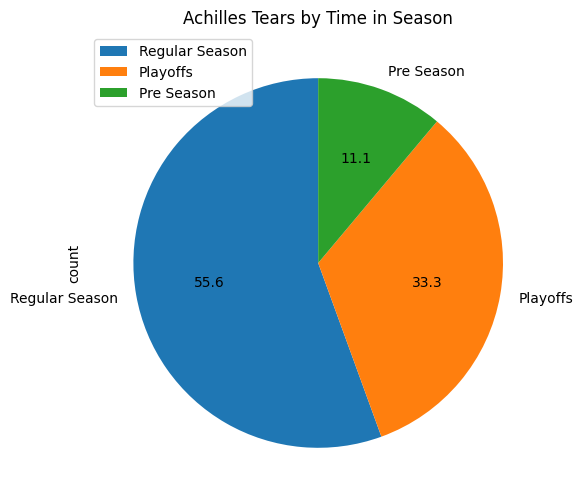

In [19]:
import matplotlib.pyplot as plt 

injuries_per_part_of_season.plot(kind='pie', 
                                 autopct='%1.1f',
                                 startangle=90,
                                 figsize=(6,6),
                                 legend=True,
                                 title='Achilles Tears by Time in Season')
plt.show()                                

In [20]:
#Combine combined date and torn achilles data 
import pandas as pd
combined_df = pd.read_csv('combined_data.csv')
achilles_df = pd.read_csv('TornAchillesData.csv')

merged_data = pd.merge(combined_df, achilles_df, on='Player', how='inner')
merged_data.to_csv('merged_data.csv', index=False)

In [21]:
#Enginner Pre Injury Load Stats
#Pullling Per Game Player Stats
from nba_api.stats.endpoints import playergamelog, commonplayerinfo
from nba_api.stats.static import players
from datetime import datetime 
import time 

def get_player_games_before_injury(player_name, injury_date, season):
    player_id = get_player_id(player_name)
    if not player_id:
        return None

    gamelog = playergamelog.PlayerGameLog(player_id=player_id, season=season, season_type_all_star='Regular Season')
    df = gamelog.get_data_frames()[0]
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    injury_date = pd.to_datetime(injury_date)
    return df[df['GAME_DATE'] < injury_date].sort_values('GAME_DATE')
    
def format_season(year_str):
    year = int(year_str)
    next_year_short = str(year + 1)[-2:]  
    return f"{year}-{next_year_short}"

def get_player_gamelog(player_id, season_str):
    try:
        print(f"Using player ID: {player_id} for season {season_str}")
        all_dfs = []
        for season_type in ['Pre Season', 'Regular Season', 'Playoffs']:
            time.sleep(1.2)  # avoid rate limits
            gamelog = playergamelog.PlayerGameLog(
                player_id=player_id,
                season=season_str,
                season_type_all_star=season_type
            )
            df = gamelog.get_data_frames()[0]
            if not df.empty:
                df['SEASON_TYPE'] = season_type
                all_dfs.append(df)

        if not all_dfs:
            print(f"No games found for player ID {player_id} in {season_str}")
            return None

        full_df = pd.concat(all_dfs, ignore_index=True)
        full_df['GAME_DATE'] = pd.to_datetime(full_df['GAME_DATE'], errors='coerce')
        
        return full_df

    except Exception as e:
        print(f"Error fetching logs for player ID {player_id}: {e}")
        return None



#Load Stats
def compute_load_stats(games_df, num_games=5):

    
    if games_df is None or games_df.empty:
        return None 

    recent_games = games_df.head(num_games)
    recent_games = recent_games.copy()

    try:
        recent_games['MIN'] = recent_games['MIN'].str.replace(':', '.').astype(float)
    except:
        recent_games['MIN'] = recent_games['MIN'].astype(float)

    avg_minutes = recent_games['MIN'].mean()
    avg_fg_attempts = recent_games['FGA'].astype(float).mean()
    load_score = avg_minutes + 0.2 * avg_fg_attempts 

    return {
        'avg_minutes_last_5': round(avg_minutes, 2),
        'avg_fg_attempts_last_5': round(avg_fg_attempts, 2),
        'load_score_last_5': round(load_score, 2)
    }

#Loops through data
engineered_rows = [] 
injury_df = pd.read_csv("merged_data.csv")
for idx, row in injury_df.iterrows():
    player = row['Player']
    injury_date = row['Date Of Injury']
    season = row['Season']
    season_type = row['Type Of Game']

    print(f"Processing {player} for {season} season")

    season_raw = str(row['Season']).strip().split("-")[0]  # "2024"
    season = format_season(season_raw)  # "2024-25"
    print(f"Using season string for API: {season}")
    injury_date = pd.to_datetime(row['Date Of Injury'], errors='coerce')
    games_before = get_player_games_before_injury(player, injury_date, season)
    stats = compute_load_stats(games_before)

    if stats:
        full_row = row.to_dict()
        full_row.update(stats)
        engineered_rows.append(full_row)

    time.sleep(1.5)

injury_load_df = pd.DataFrame(engineered_rows)
injury_load_df.to_csv("injury_load_stats.csv", index=False)
print("Load stats engineered and saved")

Processing Chris Clemons for 2020-21 season
Using season string for API: 2020-21
Searching for player: 'Chris Clemons'
Using player ID: 1629598 for Chris Clemons
Processing Brandon Clarke for 2022-23 season
Using season string for API: 2022-23
Searching for player: 'Brandon Clarke'
Using player ID: 1629634 for Brandon Clarke
Processing James Wiseman for 2024-25 season
Using season string for API: 2024-25
Searching for player: 'James Wiseman'
Using player ID: 1630164 for James Wiseman
Processing Isaiah Jackson  for 2024-25 season
Using season string for API: 2024-25
Searching for player: 'Isaiah Jackson'
Using player ID: 1630543 for Isaiah Jackson
Processing Dru Smith for 2024-25 season
Using season string for API: 2024-25
Searching for player: 'Dru Smith'
Using player ID: 1630696 for Dru Smith
Processing Dejounte Murray for 2024-25 season
Using season string for API: 2024-25
Searching for player: 'Dejounte Murray'
Using player ID: 1627749 for Dejounte Murray
Processing Damian Lillard f

In [22]:
#Merge all csv files 
import pandas as pd

df1 = pd.read_csv('combined_data.csv')
df2 = pd.read_csv('TornAchillesData.csv')
df3 = pd.read_csv('injury_load_stats.csv')

def clean_cols(df):
    df.columns = df.columns.str.strip().str.lower()
    return df

df1 = clean_cols(df1)
df2 = clean_cols(df2)
df3 = clean_cols(df3)

dup_df1_df2 = set(df1.columns).intersection(df2.columns) - {'player'}
dup_df1_df3 = set(df1.columns).intersection(df3.columns) - {'player'}
dup_df2_df3 = set(df2.columns).intersection(df3.columns) - {'player'}

df2_clean = df2.drop(columns=dup_df1_df2)
df3_clean = df3.drop(columns=dup_df1_df3.union(dup_df2_df3))

final_data = pd.merge(df1, df2_clean, on='player', how='inner')
final_data = pd.merge(final_data, df3_clean, on='player', how='inner')

# Save final clean dataframe
final_data.to_csv('final_data.csv', index=False)


In [23]:
pip install nba_api pandas tqdm 

Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd 
from nba_api.stats.endpoints import playergamelog 
from nba_api.stats.static import players
from datetime import datetime, timedelta
from tqdm import tqdm
import time 

def engineer_features(games_df, injury_date):
    games_df = games_df[games_df['GAME_DATE'] < injury_date]
    games_df = games_df.sort_values('GAME_DATE')

    #Rolling Minutes 
    games_df['rolling_minutes_5'] = games_df['MIN'].rolling(window=5).mean()
    games_df['rolling_minutes_10'] = games_df['MIN'].rolling(window=10).mean()
    games_df['rolling_minutes_15'] = games_df['MIN'].rolling(window=15).mean()
    games_df['std_minutes_10'] = games_df['MIN'].rolling(window=10).std()

    #Back to Back Games Flag
    games_df['days_between'] = games_df['GAME_DATE'].diff().dt.days
    games_df['back_to_back'] = games_df['days_between'] == 1
    games_df['3_in_4'] = games_df['GAME_DATE'].diff(periods=3).dt.days <= 4

    return games_df.iloc[-1:]


def build_dataset(final_df):
    features_rows = []

    for _, row in tqdm(final_df.iterrows(), total=len(final_df)):
        player_name = row['player'] 
        season = row['season']
        injury_date = pd.to_datetime(row['injury date'])

        player_id = get_player_id(player_name)
        if not player_id:
            print(f"Could not find ID for {player_name}")
            continue 

        gamelog_df = get_player_gamelog(player_id, season)
        if gamelog_df.empty:
            continue

        gamelog_df['MIN'] = pd.to_numeric(gamelog_df['MIN'], errors='coerce')
        features = engineer_features(gamelog_df, injury_date)

        if not features.empty:
            features = features[['rolling_minutes_5', 'rolling_minutes_10', 'rolling_minutes_15', 'std_minutes_10', 'back_to_back', '3_in_4']]
            features['player'] = player_name 
            features_rows.append(features) 

        time.sleep(1.5) 

    if features_rows:
        return pd.concat(features_rows, ignore_index=True)
    else:
        return pd.DataFrame() 

In [25]:
final_df = pd.read_csv('final_data.csv')
final_df['injury date'] = pd.to_datetime(final_df['injury date'])

rolling_features_df = build_dataset(final_df)

enriched_df = pd.merge(final_df, rolling_features_df, on='player', how='left')
enriched_df.to_csv("final_data_with_features.csv", index=False) 
print("Saved as final_data_with_features.csv") 

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Searching for player: 'Brandon Clarke'
Using player ID: 1629634 for Brandon Clarke
Using player ID: 1629634 for season 2022-23


 14%|██████▍                                      | 1/7 [00:05<00:31,  5.32s/it]

Searching for player: 'Isaiah Jackson'
Using player ID: 1630543 for Isaiah Jackson
Using player ID: 1630543 for season 2024-25


 29%|████████████▊                                | 2/7 [00:10<00:26,  5.32s/it]

Searching for player: 'Dru Smith'
Using player ID: 1630696 for Dru Smith
Using player ID: 1630696 for season 2024-25


 43%|███████████████████▎                         | 3/7 [00:15<00:21,  5.33s/it]

Searching for player: 'Dejounte Murray'
Using player ID: 1627749 for Dejounte Murray
Using player ID: 1627749 for season 2024-25


 57%|█████████████████████████▋                   | 4/7 [00:21<00:16,  5.34s/it]

Searching for player: 'Damian Lillard'
Using player ID: 203081 for Damian Lillard
Using player ID: 203081 for season 2024-25


 71%|████████████████████████████████▏            | 5/7 [00:26<00:10,  5.33s/it]

Searching for player: 'Jayson Tatum'
Using player ID: 1628369 for Jayson Tatum
Using player ID: 1628369 for season 2024-25


 86%|██████████████████████████████████████▌      | 6/7 [00:32<00:05,  5.34s/it]

Searching for player: 'Tyrese Haliburton'
Using player ID: 1630169 for Tyrese Haliburton
Using player ID: 1630169 for season 2024-25


100%|█████████████████████████████████████████████| 7/7 [00:37<00:00,  5.35s/it]

Saved as final_data_with_features.csv


Sucessfully loaded final_data_with_features.csv. Shape: (7, 26)

Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player                       7 non-null      object 
 1   injury date                  7 non-null      object 
 2   season                       7 non-null      object 
 3   team name                    7 non-null      object 
 4   games played before injury   7 non-null      int64  
 5   average minutes per game     7 non-null      float64
 6   minutes in last week         7 non-null      int64  
 7   minutes in last month        7 non-null      int64  
 8   rest days before injury      7 non-null      int64  
 9   team pace                    7 non-null      float64
 10  estimated minutes at injury  7 non-null      object 
 11  opponent pace                7 non-null      float64
 12  date 

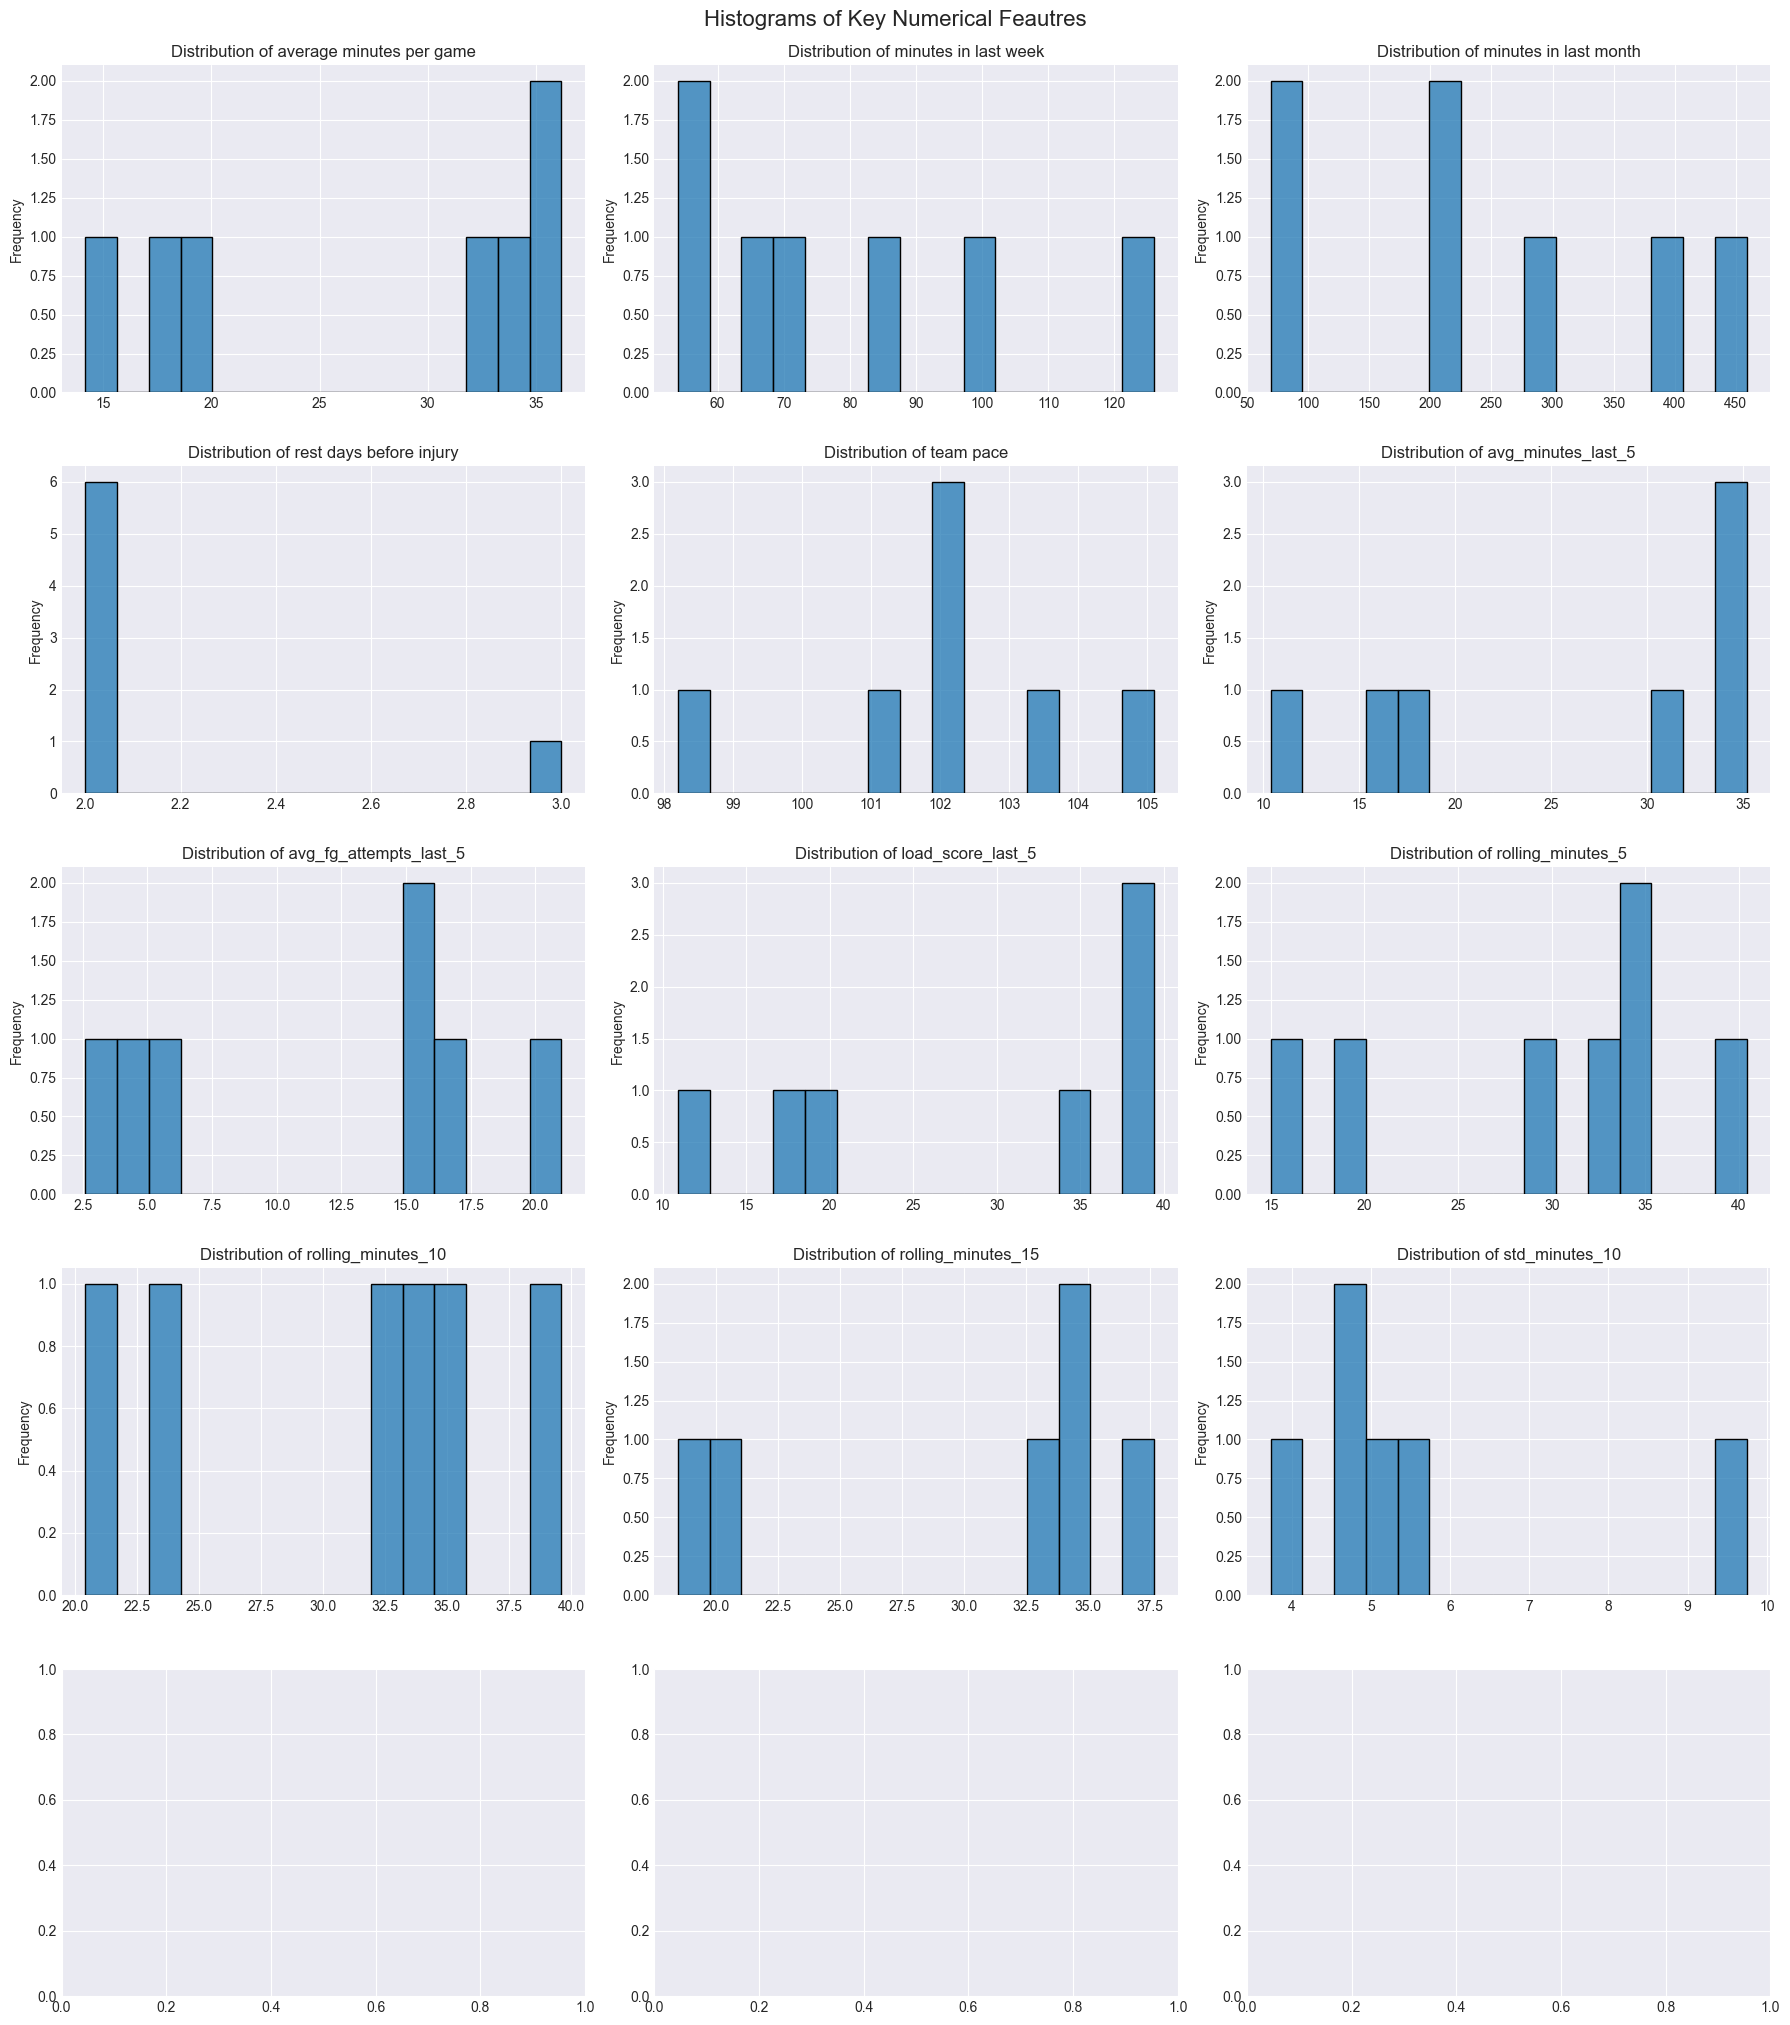


 Correlation Matrix: 


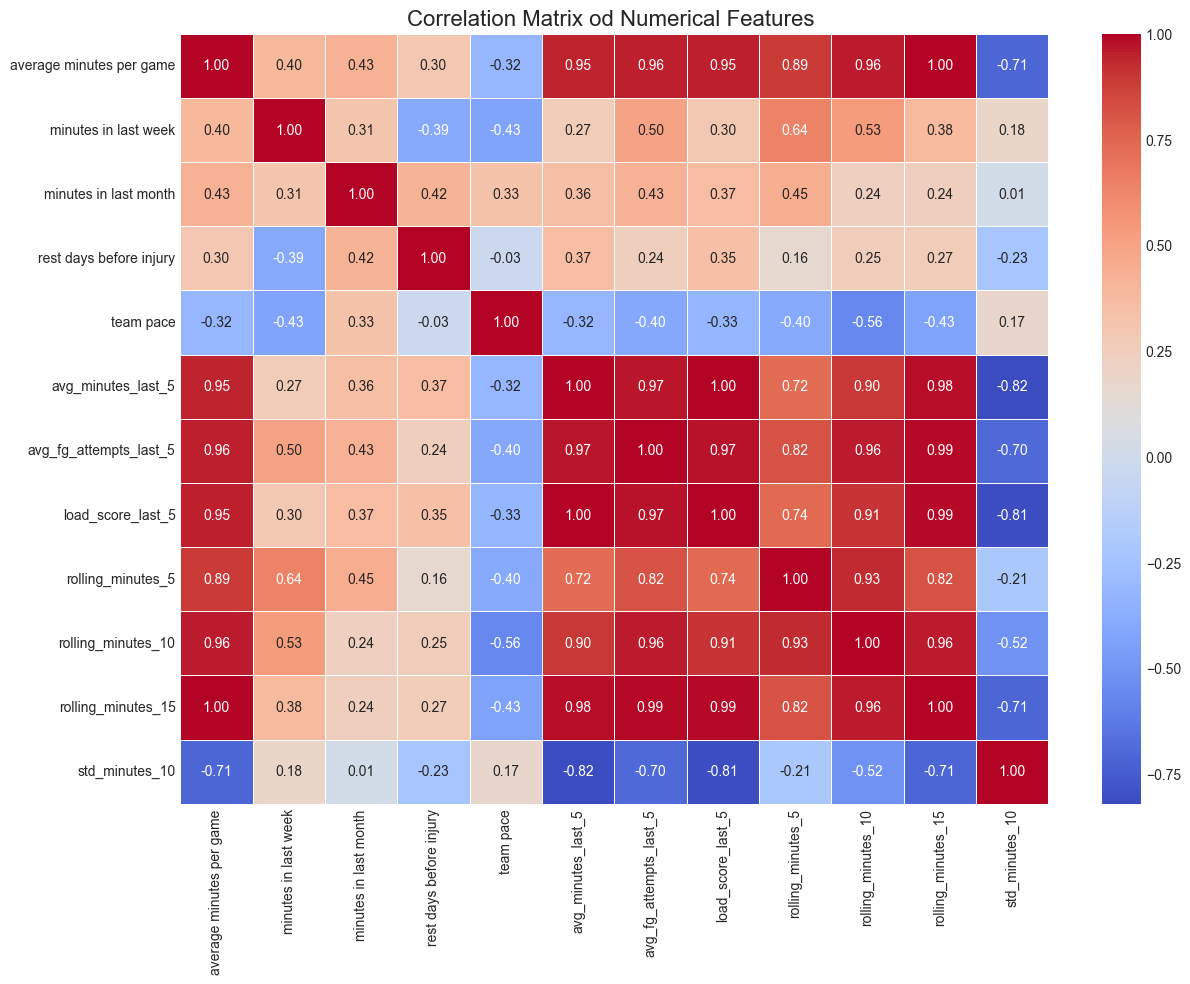

Scattered Plots: 


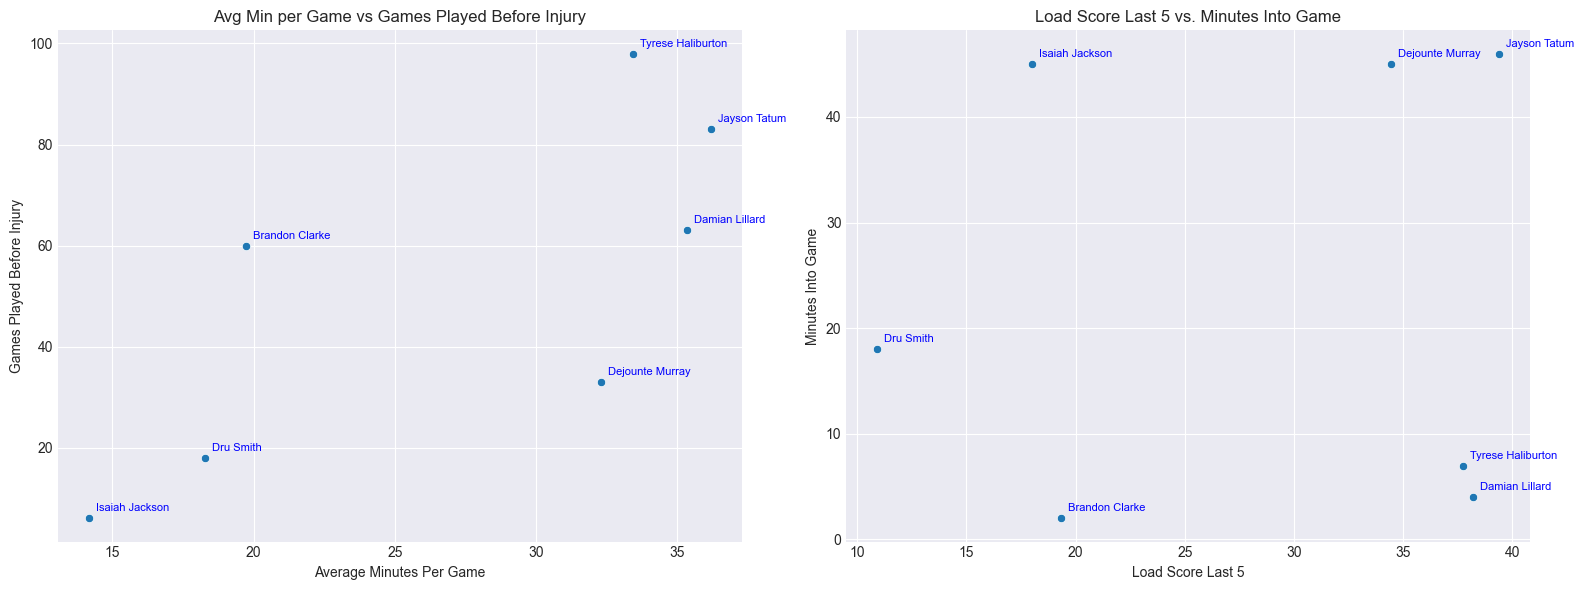

                games played before injury  average minutes per game  \
type of game                                                           
Playoffs                             63.00                 35.333333   
Playoffs                             90.50                 34.804647   
Regular Season                       29.25                 21.120202   

                minutes_into_game_numeric  load_score_last_5  
type of game                                                  
Playoffs                              4.0              38.20  
Playoffs                             26.5              38.56  
Regular Season                       27.5              20.67  


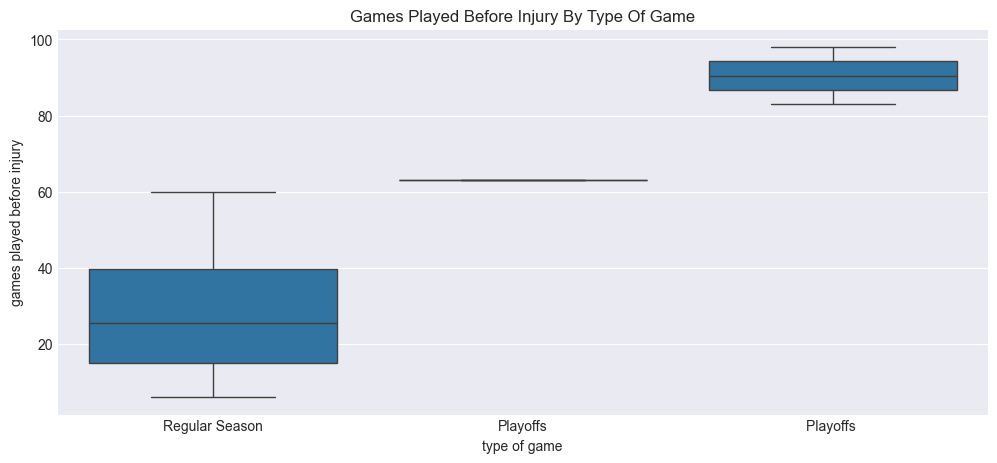

              games played before injury  average minutes per game  \
back_to_back                                                         
0                                   56.6                 30.282465   
1                                   39.0                 19.005556   

              minutes_into_game_numeric  load_score_last_5  
back_to_back                                                
0                                  29.4             33.552  
1                                  10.0             15.120  


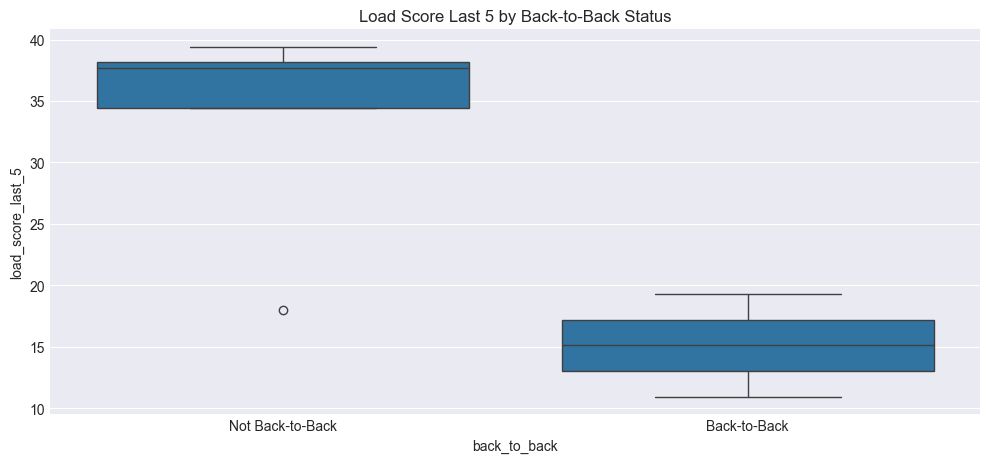


Player: Brandon Clarke (Index: 0)
 Player: Brandon Clarke
 Injury Date: 2023-03-03 00:00:00
 Games Played Before Injury: 60.0
 Average Minutes Per Game: 19.7
 Minutes In Last Month: 221.0
 Rest Days Before Injury: 2.0
 Minutes_Into_Game_Numeric: 2.0
Back_to_Back Yes
 Type Of Game: Regular Season
 Load_Score_Last_5: 19.3
 Std_Minutes_10: 5.0

Player: Isaiah Jackson  (Index: 1)
 Player: Isaiah Jackson 
 Injury Date: 2024-11-01 00:00:00
 Games Played Before Injury: 6.0
 Average Minutes Per Game: 14.2
 Minutes In Last Month: 85.0
 Rest Days Before Injury: 2.0
 Minutes_Into_Game_Numeric: 45.0
Back_to_Back No
 Type Of Game: Regular Season
 Load_Score_Last_5: 18.0
 Std_Minutes_10: nan

Player: Dru Smith (Index: 2)
 Player: Dru Smith
 Injury Date: 2024-12-23 00:00:00
 Games Played Before Injury: 18.0
 Average Minutes Per Game: 18.3
 Minutes In Last Month: 209.0
 Rest Days Before Injury: 2.0
 Minutes_Into_Game_Numeric: 18.0
Back_to_Back Yes
 Type Of Game: Regular Season
 Load_Score_Last_5: 10.

In [26]:
#Validate Final Feature Set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Load Data
file_path = 'final_data_with_features.csv'
try:
    df = pd.read_csv(file_path)
    print(f"Sucessfully loaded {file_path}. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: {file_path} not found.")
    exit()

#Inspect Data 
print("\nData Info: ")
df.info()

print("\nFirst 5 rows: ")
print(df.head())

print("\nColumn names and data types: ")
print(df.dtypes)

#Data Cleaning and Processing 
if 'back_to_back' in df.columns:
    df['back_to_back'] = df['back_to_back'].astype(int)
    print("Converted back-to-back to integers") 

if 'injury date' in df.columns:
    df['injury date'] = pd.to_datetime(df['injury date'], errors='coerce')
    print("Converted injury date to datetime")

#Parse time into game to numerical data
# Parse time into game to numerical data
def parse_time_into_game_numerical(time_str):
    time_str = str(time_str).lower()
    if '1st' in time_str:
        if '~' in time_str:
            try:
                minutes_part = time_str.split('~')[1].split(' ')[0]
                if '-' in minutes_part:
                    start,end = map(float, minutes_part.split('-'))
                    return (start + end) / 2
                else:
                    return float(minutes_part.split(':')[0]) + float(minutes_part.split(':')[1])/60 if ':' in minutes_part else float(minutes_part)
            except:
                return np.nan
        elif 'early 1st' in time_str: return 3
        elif 'mid 1st' in time_str: return 6
        elif 'late 1st' in time_str: return 9
    elif '2nd' in time_str:
        base_minutes = 12
        if '~' in time_str:
            try:
                minutes_part = time_str.split('~')[1].split(' ')[0]
                if '-' in minutes_part:
                    start,end = map(float, minutes_part.split('-'))
                    return base_minutes + (start + end) /2
                else:
                    # Corrected: Ensured all parentheses are matched
                    return base_minutes + (float(minutes_part.split(':')[0]) + float(minutes_part.split(':')[1])/60 if ':' in minutes_part else float(minutes_part))
            except:
                return np.nan
        elif 'early 2nd' in time_str: return base_minutes + 3
        elif 'mid 2nd' in time_str: return base_minutes + 6
        elif 'late 2nd' in time_str: return base_minutes + 9
    elif '3rd' in time_str:
        base_minutes = 24
        if '~' in time_str:
            try:
                minutes_part = time_str.split('~')[1].split(' ')[0]
                if '-' in minutes_part:
                    start,end = map(float, minutes_part.split('-'))
                    return base_minutes + (start + end) / 2
                else:
                    # Corrected: Added missing closing parenthesis here
                    return base_minutes + (float(minutes_part.split(':')[0]) + float(minutes_part.split(':')[1])/60 if ':' in minutes_part else float(minutes_part))
            except:
                return np.nan
        elif 'early 3rd' in time_str: return base_minutes + 3
        elif 'mid 3rd' in time_str: return base_minutes + 6
        elif 'late 3rd' in time_str: return base_minutes + 9
    elif '4th' in time_str:
        base_minutes = 36
        if '~' in time_str:
            try:
                minutes_part = time_str.split('~')[1].split(' ')[0]
                if 'min left' in time_str:
                    clean_minutes_part = minutes_part.replace('min left', '').strip()
                    if '-' in clean_minutes_part:
                        start_min_left, end_min_left = map(float, clean_minutes_part.split('-'))
                        return 48 - (start_min_left + end_min_left) /2
                    elif ':' in clean_minutes_part:
                        mins = float(clean_minutes_part.split(':')[0])
                        secs = float(clean_minutes_part.split(':')[1]) / 60
                        return 48 - (mins + secs)
                    else:
                        return 48 - float(clean_minutes_part)
                elif ':' in minutes_part:
                    mins = float(minutes_part.split(':')[0])
                    secs = float(minutes_part.split(':')[1]) / 60
                    # Corrected: base_miutes -> base_minutes
                    return base_minutes + mins + secs
                else:
                    return base_minutes + float(minutes_part)
            except:
                return np.nan
        elif 'early 4th' in time_str: return base_minutes + 3
        elif 'mid 4th' in time_str: return base_minutes + 6
        elif 'late 4th' in time_str: return 45
    return np.nan # This line will now be parsed correctly
                      
df['minutes_into_game_numeric'] = df['time into game'].apply(parse_time_into_game_numerical)
print("Added minutes into game in a numeric format")
print(df[['time into game', 'minutes_into_game_numeric']].head())

#Adding Season Segment 
bins = [0, 20, 50, df['games played before injury'].max() + 1]
labels = ['Early Season', 'Mid Season', 'Late Season']

df['season_segment'] = pd.cut(df['games played before injury'], bins=bins, labels=labels, right=False)
print(df['season_segment'].value_counts())
print(f"Number of NaN in 'season_segment' after binning: {df['season_segment'].isnull().sum()}")

#Drop Null Values 
df.dropna(subset=['season_segment'], inplace=True)

#Feature Uniqueness and Distribution Analysis
print("Categorical Features: ")
categorical_cols = ['team name', 'opponent', 'type of game']
for col in categorical_cols:
    if col in df.columns:
        print(f"\n'{col}' unique values and counts:")
        print(df[col].value_counts())
    else:
        print(f"Warning: Column '{col}' not found.")
if 'back_to_back' in df.columns:
    print(f"\n'back_to_back' unique values and counts:")
    print(df['back_to_back'].value_counts())

print("\n Numerical  Features Descriptive Statics: ")
numerical_features_for_desc = ['game played before injury', 'average minutes per game', 'minutes in last week', 
                              'minutes in last month', 'rest days before injury', 'team pace', 'avg_minutes_last_5', 
                              'avg_fg_attempts_last_5', 'load_score_last_5', 'rolling_minutes_5', 'rolling_minutes_10',
                              'rolling_minutes_15', 'std_minutes_10', 'minutes_into_game_numerical']

numerical_features_for_desc = [col for col in numerical_features_for_desc if col in df.columns]
print(df[numerical_features_for_desc].describe().T)

print("Numerical Features Distributions: ")
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18,20))
axes = axes.flatten()

for i, col in enumerate(numerical_features_for_desc):
    sns.histplot(df[col].dropna(), kde=False, ax=axes[i], bins=15)
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].set_xlabel(' ')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Histograms of Key Numerical Feautres', y=1.01, fontsize=16)
plt.show()

#Feature Relevance 
print("\n Correlation Matrix: ")
numerical_cols_for_corr = df[numerical_features_for_desc].select_dtypes(include=np.number).columns.tolist()
if numerical_cols_for_corr:
    plt.figure(figsize=(14,10))
    sns.heatmap(df[numerical_cols_for_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix od Numerical Features ', fontsize=16)
    plt.show()
else:
    print("No numerical columns found")

print("Scattered Plots: ")
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
sns.scatterplot(x='average minutes per game', y='games played before injury', data=df)
plt.title('Avg Min per Game vs Games Played Before Injury')
plt.xlabel('Average Minutes Per Game')
plt.ylabel('Games Played Before Injury')

#Add player names as annotation
for i, row in df.iterrows():
    plt.annotate(
        row['player'],
        (row['average minutes per game'], row['games played before injury']),
        textcoords="offset points",
        xytext=(5,5),
        ha='left',
        fontsize=8,
        color='blue'
    )

plt.subplot(1,2,2)
sns.scatterplot(x='load_score_last_5', y='minutes_into_game_numeric', data=df)
plt.title('Load Score Last 5 vs. Minutes Into Game')
plt.xlabel('Load Score Last 5')
plt.ylabel('Minutes Into Game')

#Add player names as annotation
for i, row in df.iterrows():
    plt.annotate(
        row['player'],
        (row['load_score_last_5'], row['minutes_into_game_numeric']),
        textcoords="offset points",
        xytext=(5,5),
        ha='left',
        fontsize=8,
        color='blue'
    )

plt.tight_layout()
plt.show()

if 'type of game' in df.columns:
    # Corrected indentation and missing closing parenthesis for .mean()
    print(df.groupby('type of game')[['games played before injury', 'average minutes per game', 'minutes_into_game_numeric', 'load_score_last_5']].mean())
    plt.figure(figsize=(12, 5)) # Corrected indentation and parentheses for figsize
    sns.boxplot(x='type of game', y='games played before injury', data=df)
    plt.title('Games Played Before Injury By Type Of Game')
    plt.show()
else:
    print("Column 'type of game' not found for grouped analysis.")


#Groups Analysis
if 'back_to_back' in df.columns: 
    print(df.groupby('back_to_back')[['games played before injury', 'average minutes per game', 'minutes_into_game_numeric', 'load_score_last_5']].mean())
    plt.figure(figsize=(12, 5)) 
    sns.boxplot(x='back_to_back', y='load_score_last_5', data=df)
    plt.title('Load Score Last 5 by Back-to-Back Status') 
    plt.xticks(ticks=[0, 1], labels=['Not Back-to-Back', 'Back-to-Back']) 
    plt.show()
else:
    print("Column 'back_to_back' not found for grouped analysis.")

#Indivual Case Review 
display_cols = ['player', 'injury date', 'season_segement', 'games played before injury',
               'average minutes per game', 'mimutes in last week', 'minutes in last month',
               'rest days before injury', 'minutes_into_game_numeric', 'back_to_back', 'type of game',
               'load_score_last_5', 'std_minutes_10']

display_cols = [col for col in display_cols if col in df.columns]

for index, row in df.iterrows():
    print(f"\nPlayer: {row['player']} (Index: {index})")
    for col in display_cols:
        if col in ['games played before injury', 'average minutes per game', 'minutes in last week',
                   'minutes in last month', 'rest days before injury', 'minutes_into_game_numeric', 
                   'load_score_last_5', 'std_minutes_10']:
            print(f" {col.replace('-', ' ').title()}: {row[col]:.1f}") 
        elif col == "back_to_back":
            print(f"Back_to_Back {'Yes' if row[col] else 'No'}")
        else:
            print(f" {col.replace('-', ' ').title()}: {row[col]}")

print("\nFeature Validation Completed") 